<a href="https://colab.research.google.com/github/Mithunjha/Segmentation/blob/main/170389M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [62]:
!pip install itk itkwidgets ipywidgets
import itk
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider #ToggleButtons, interact 
from itkwidgets import view
import numpy as np


# Preliminaries

In [63]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [64]:
def read_image(file_name):
    input_image = itk.imread(file_name)
    input_image = itk.array_from_image(input_image)
    input_image = (input_image/np.max(input_image))*255
    input_image = itk.image_from_array(input_image)
    return input_image

In [65]:

base = '/content/drive/MyDrive/Brats2018/Brats18_2013_10_1_'#brats2018/Brats18_2013_10_1_'

flair_fn = base + 'flair.nii'
t1_fn = base + 't1.nii'
t1ce_fn = base + 't1ce.nii'
t2_fn = base + 't2.nii'
seg_fn = base + 'seg.nii'

flair = read_image(flair_fn)
t1 = read_image(t1_fn)
t1ce = read_image(t1ce_fn)
t2 = read_image(t2_fn)
seg = read_image(seg_fn)

print("Shape of Images : ",flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)

Shape of Images :  (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240)


In [164]:
def dice_coeffiecient(ground_truth, prediction):
  intersection = np.sum(ground_truth * prediction)
  score = (2. * intersection) / (np.sum(prediction) + np.sum(ground_truth))
  return score

In [5]:
thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices
# set true for continuous_update

# Define a function for plotting images
def plot_slices(slice):
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)


# Use the interactive() tool to create the visualization
interactive(plot_slices, slice=select_slice)  

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

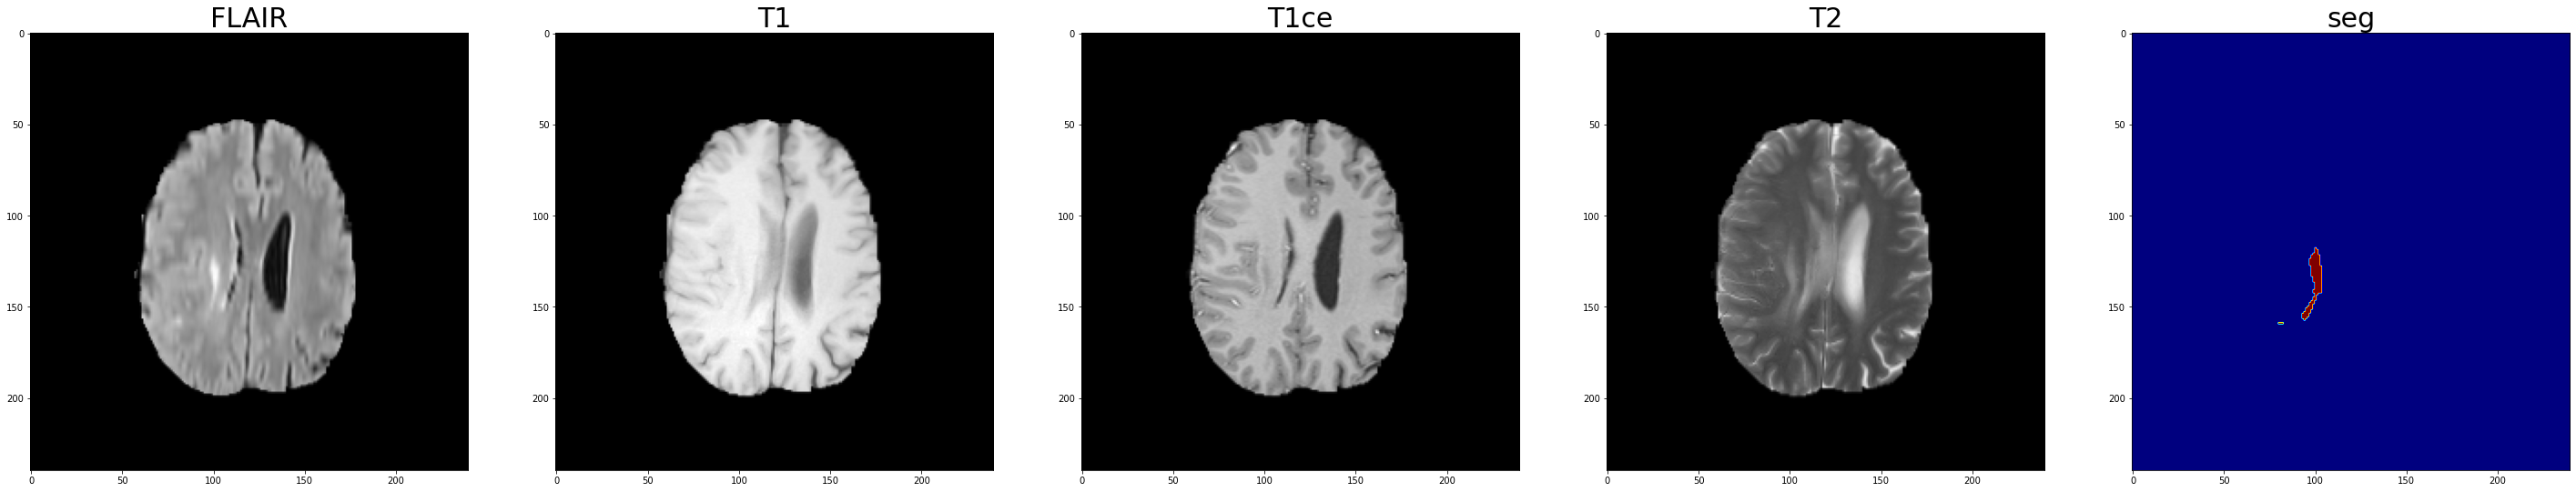

In [ ]:
# individually analyse each slice

slice = 100

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 30)
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 30); # Jet cmap is used

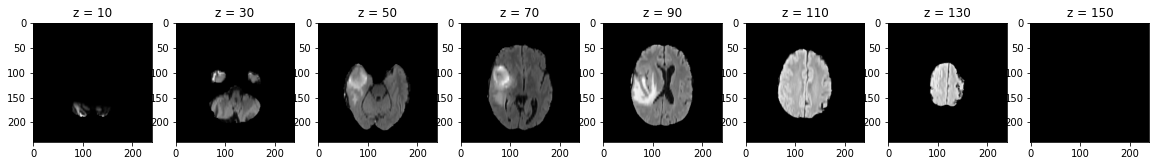

In [6]:
image = flair #change image from here => [flair,t1,t1ce,t2,seg]

fig, ax = plt.subplots(1, 8, figsize=(20,160))
slices = [10, 30, 50, 70, 90, 110, 130, 150]
for i, z in enumerate(slices):
    ax[i].imshow(image[z],cmap='gray')
    ax[i].set_title('z = {}'.format(z))

# SEGMENTATION

## 1. Connected threshold 
The criterion used by the ConnectedThresholdImageFilter is based on an interval of intensity values provided by the user. Lower and upper threshold values should be provided. The regiongrowing algorithm includes those pixels whose intensities are inside the interval.
$$ I(x) \in [\mathrm{lower}, \mathrm{upper}] $$

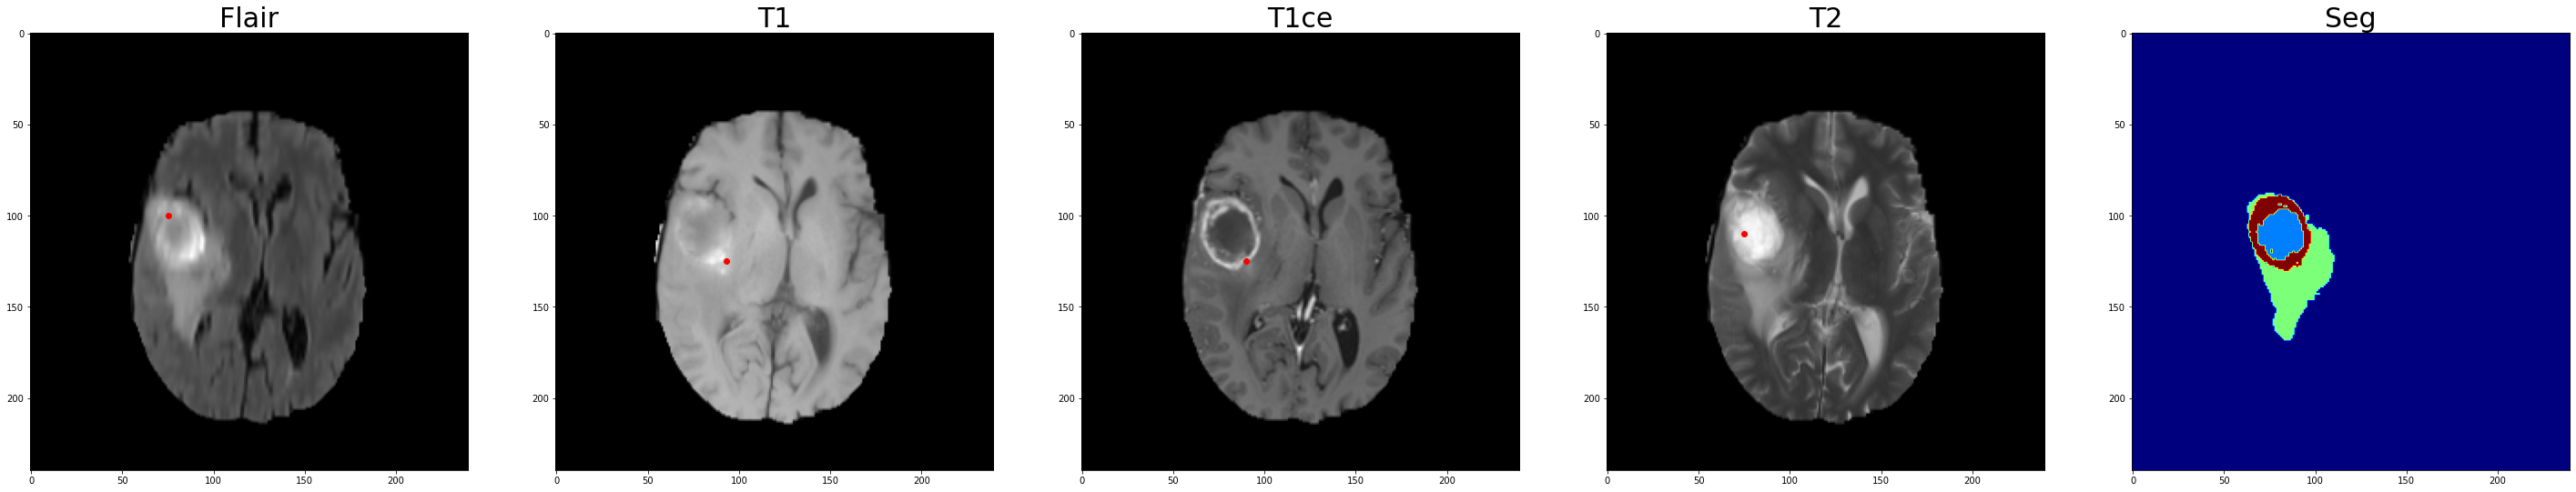

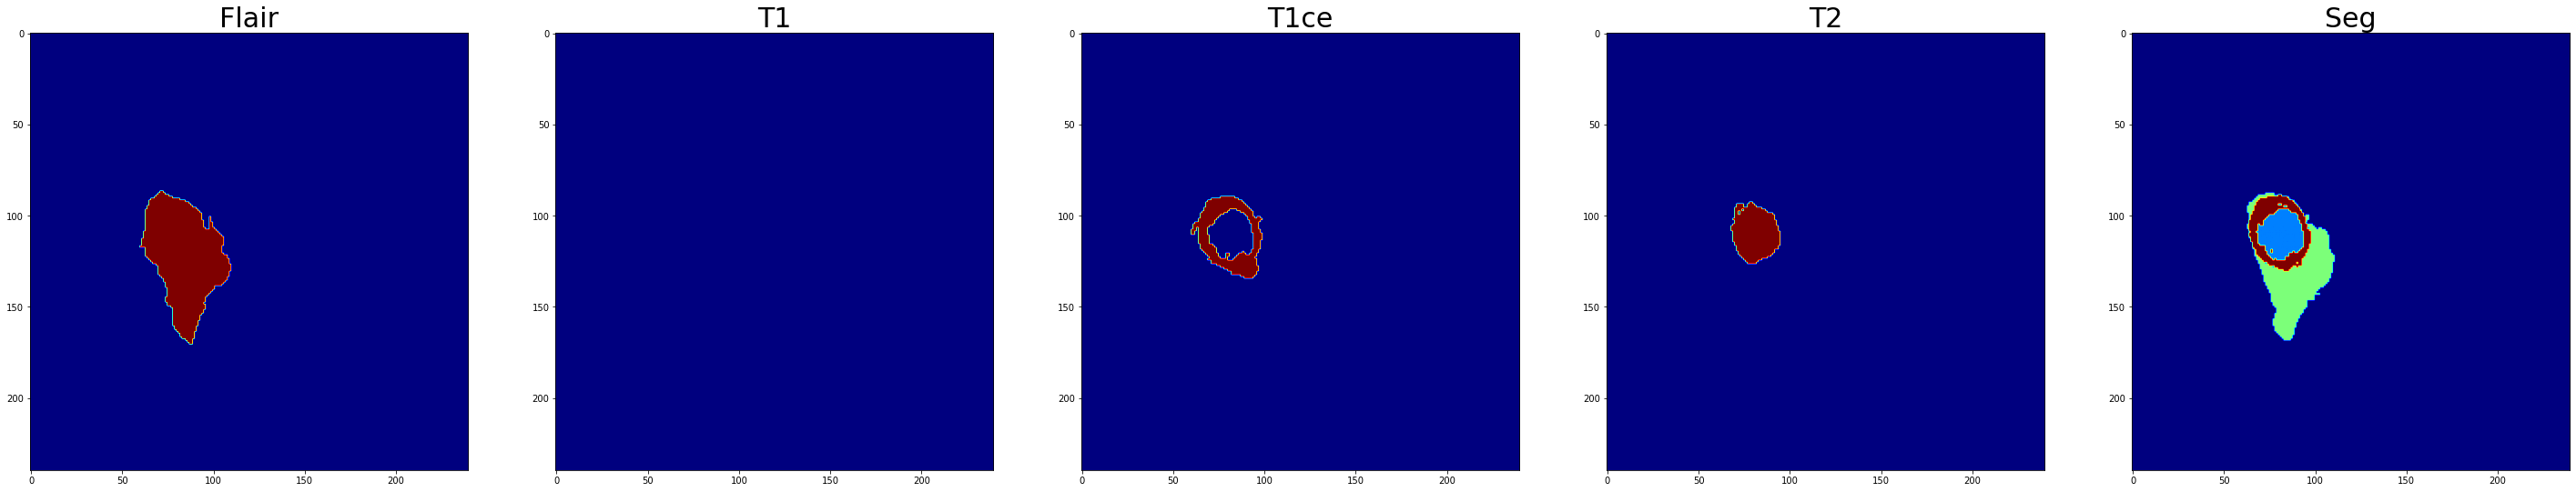

In [30]:

flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])


smoothen_flair = itk.CurvatureFlowImageFilter(flair_slice,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t1 = itk.CurvatureFlowImageFilter(t1_slice,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t1ce = itk.CurvatureFlowImageFilter(t1ce_slice,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t2 = itk.CurvatureFlowImageFilter(t2_slice,NumberOfIterations = 5, TimeStep = 0.125)

seed_flair = (75,100)
seed_t1 = (93,125)
seed_t1ce = (90,125)
seed_t2 = (75,110)
Replace_value = 255

out_flair = itk.ConnectedThresholdImageFilter(smoothen_flair, Seed = seed_flair, Lower = 105, Upper = 250, ReplaceValue = Replace_value)
out_t1 = itk.ConnectedThresholdImageFilter(smoothen_t1, Seed = seed_t1, Lower = 150, Upper = 255, ReplaceValue =Replace_value)
out_t1ce = itk.ConnectedThresholdImageFilter(smoothen_t1ce, Seed = seed_t1ce, Lower = 100, Upper = 250, ReplaceValue = Replace_value)
out_t2 = itk.ConnectedThresholdImageFilter(smoothen_t2, Seed = seed_t2, Lower = 160, Upper = 250, ReplaceValue = Replace_value)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[0].scatter(seed_flair[0],seed_flair[1],color = 'r')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[1].scatter(seed_t1[0],seed_t1[1],color = 'r')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[2].scatter(seed_t1ce[0],seed_t1ce[1],color = 'r')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[3].scatter(seed_t2[0],seed_t2[1],color = 'r')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(out_flair, cmap='jet'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(out_t1, cmap='jet'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(out_t1ce, cmap='jet'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(out_t2, cmap='jet'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30);
    


# Neighborhood Connected

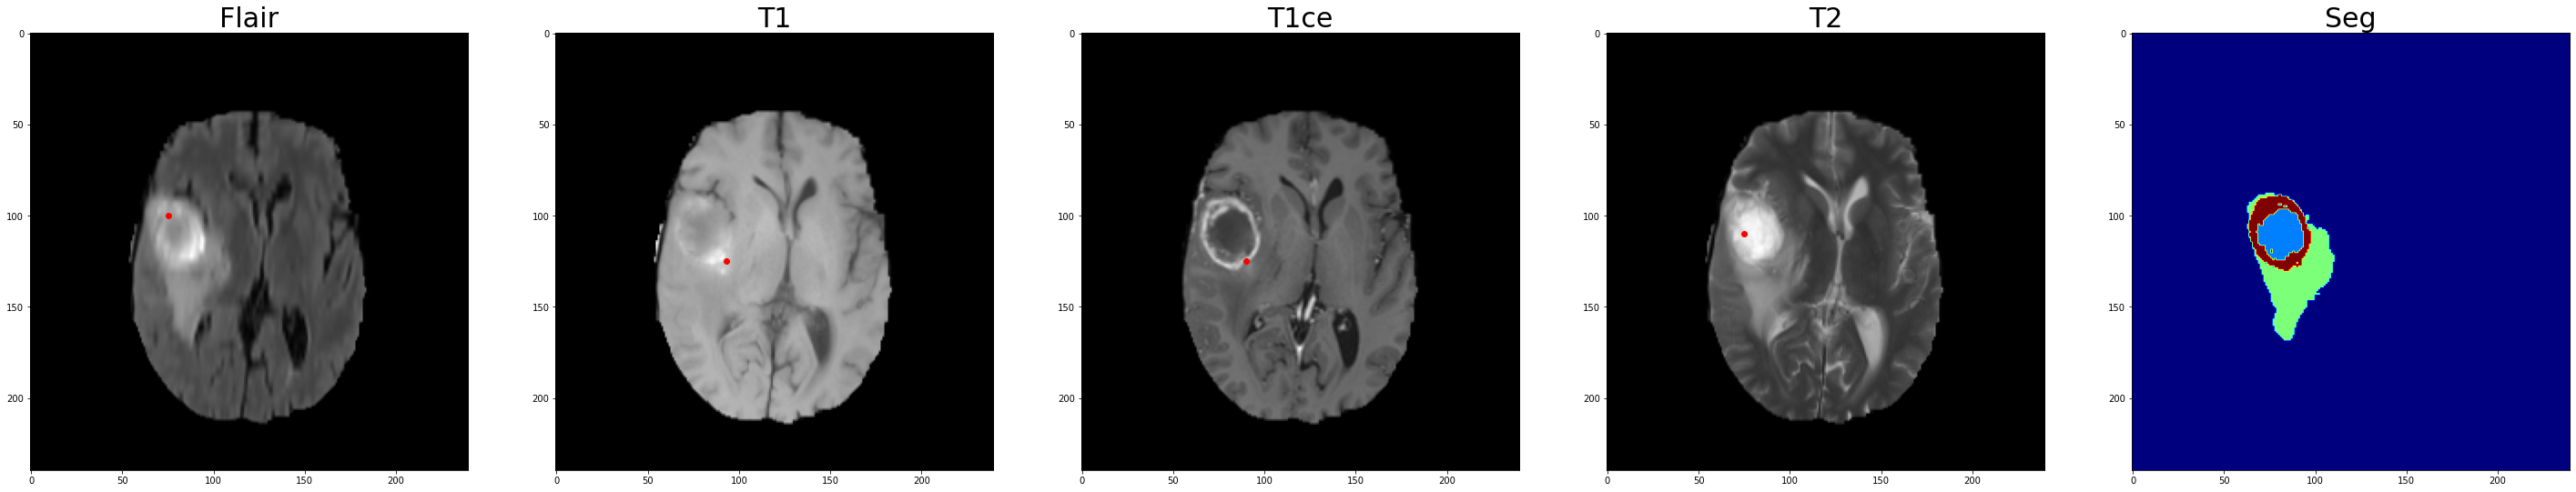

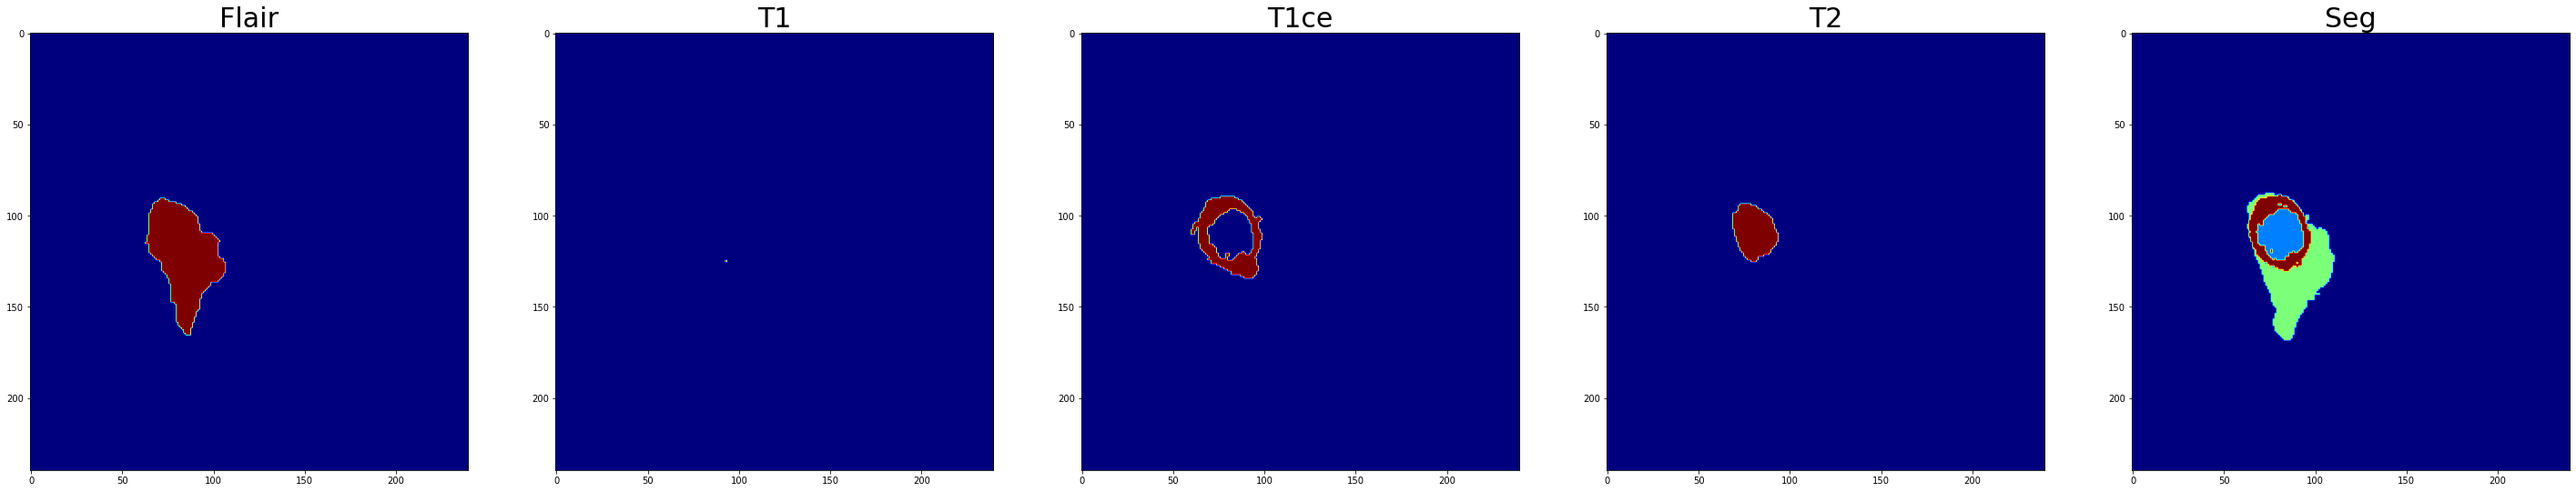

In [32]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])

filtered_flair = itk.CurvatureFlowImageFilter(flair_slice, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t1 = itk.CurvatureFlowImageFilter(t1_slice, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t1ce = itk.CurvatureFlowImageFilter(t1ce_slice, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t2 = itk.CurvatureFlowImageFilter(t2_slice, NumberOfIterations = 5, TimeStep = 0.125)

seed_flair = (75,100)
seed_t1 = (93,125)
seed_t1ce = (90,125)
seed_t2 = (75,110)
Replace_value = 255

neigh_flair = itk.NeighborhoodConnectedImageFilter(filtered_flair, Radius = 2, Lower = 105, Upper = 250, Seed = seed_flair, ReplaceValue = Replace_value)
neigh_t1 = itk.NeighborhoodConnectedImageFilter(filtered_t1, Radius = 1, Lower =180, Upper =255, Seed = seed_t1, ReplaceValue = Replace_value)
neigh_t1ce = itk.NeighborhoodConnectedImageFilter(filtered_t1ce, Radius = 0, Lower = 100, Upper = 250, Seed = seed_t1ce, ReplaceValue = Replace_value)
neigh_t2 = itk.NeighborhoodConnectedImageFilter(filtered_t2, Radius = 2, Lower =140, Upper =255, Seed = seed_t2, ReplaceValue = Replace_value)


fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[0].scatter(seed_flair[0],seed_flair[1],color = 'r')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[1].scatter(seed_t1[0],seed_t1[1],color = 'r')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[2].scatter(seed_t1ce[0],seed_t1ce[1],color = 'r')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[3].scatter(seed_t2[0],seed_t2[1],color = 'r')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(neigh_flair, cmap='jet'), ax[0].set_title('Flair',fontsize = 30);
ax[1].imshow(neigh_t1, cmap='jet'), ax[1].set_title('T1',fontsize = 30);
ax[2].imshow(neigh_t1ce, cmap='jet'), ax[2].set_title('T1ce',fontsize = 30);
ax[3].imshow(neigh_t2, cmap='jet'), ax[3].set_title('T2',fontsize = 30);
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30);
    



# Confidence Connected

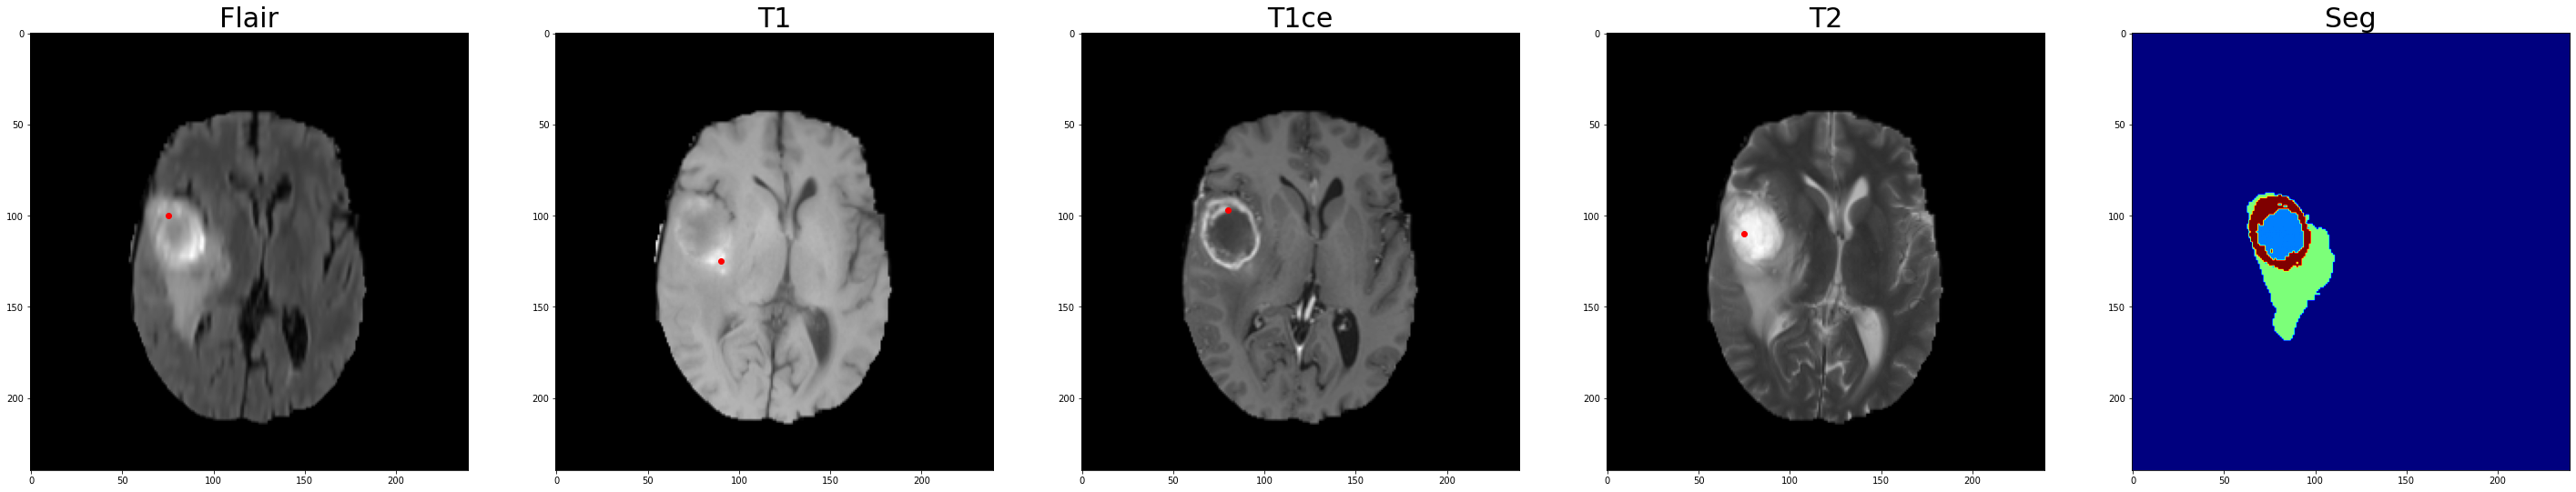

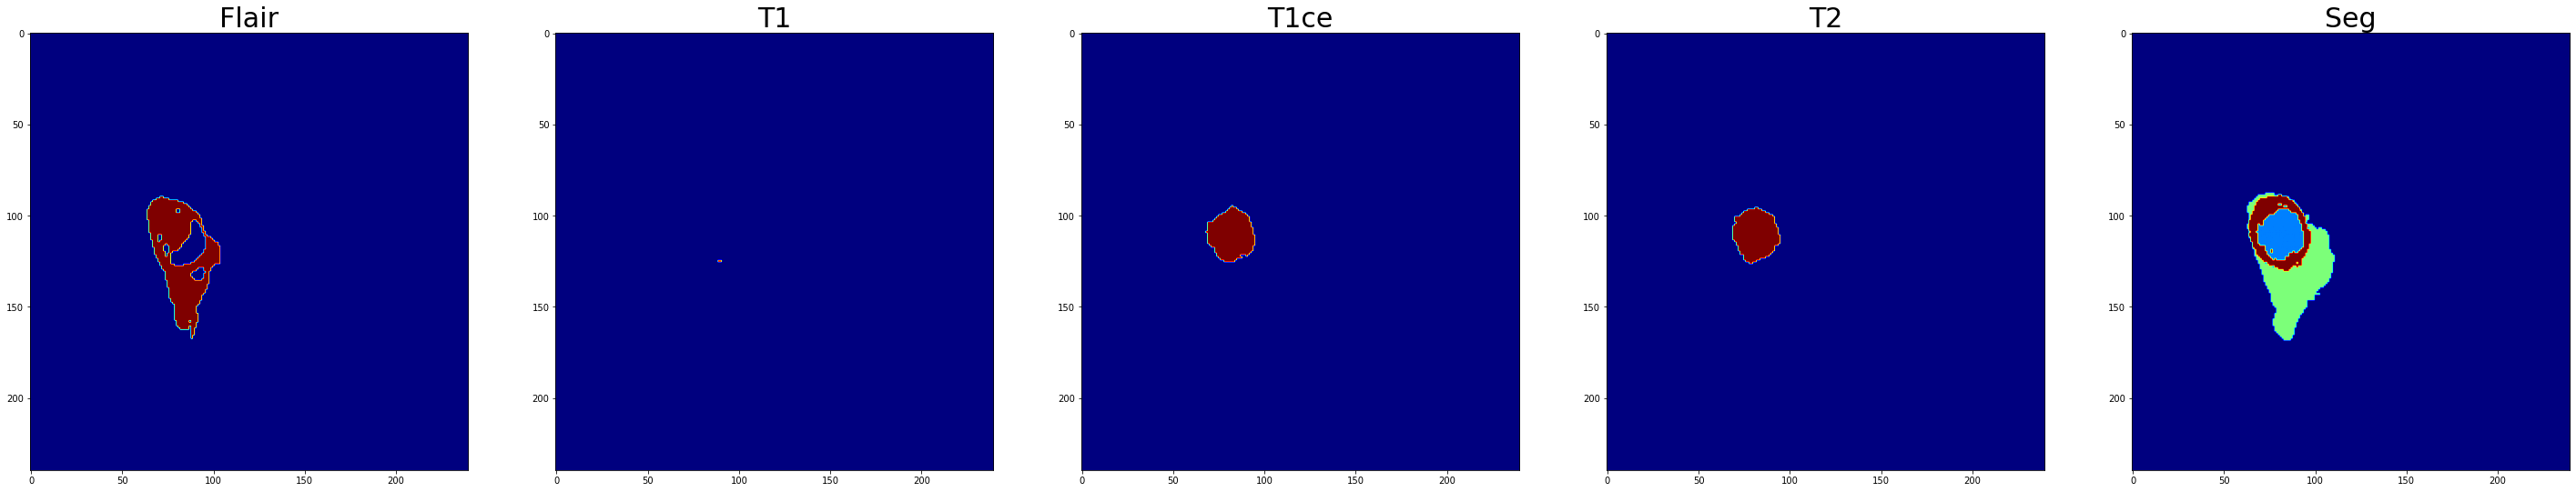

In [33]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])

filt_flair = itk.CurvatureFlowImageFilter(flair_slice, NumberOfIterations = 5, TimeStep = 0.125)
filt_t1 = itk.CurvatureFlowImageFilter(t1_slice, NumberOfIterations = 5, TimeStep = 0.125)
filt_t1ce = itk.CurvatureFlowImageFilter(t1ce_slice, NumberOfIterations = 5, TimeStep = 0.125)
filt_t2 = itk.CurvatureFlowImageFilter(t2_slice, NumberOfIterations = 5, TimeStep = 0.125)

seed_flair = (75,100)
seed_t1 = (90,125)
seed_t1ce = (80,97)
seed_t2 = (75,110)
Replace_value = 255

conf_flair = itk.ConfidenceConnectedImageFilter(filt_flair, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = seed_flair, ReplaceValue = Replace_value)
conf_t1 = itk.ConfidenceConnectedImageFilter(filt_t1, Multiplier =1, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = seed_t1, ReplaceValue = Replace_value)
conf_t1ce = itk.ConfidenceConnectedImageFilter(filt_t1ce, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 2, Seed = seed_t1ce, ReplaceValue = Replace_value)
conf_t2 = itk.ConfidenceConnectedImageFilter(filt_t2, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = seed_t2, ReplaceValue = Replace_value)


fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[0].scatter(seed_flair[0],seed_flair[1],color = 'r')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[1].scatter(seed_t1[0],seed_t1[1],color = 'r')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[2].scatter(seed_t1ce[0],seed_t1ce[1],color = 'r')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[3].scatter(seed_t2[0],seed_t2[1],color = 'r')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(conf_flair, cmap='jet'), ax[0].set_title('Flair',fontsize = 30);
ax[1].imshow(conf_t1, cmap='jet'), ax[1].set_title('T1',fontsize = 30);
ax[2].imshow(conf_t1ce, cmap='jet'), ax[2].set_title('T1ce',fontsize = 30);
ax[3].imshow(conf_t2, cmap='jet'), ax[3].set_title('T2',fontsize = 30);
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30);
    

255.0 0.0


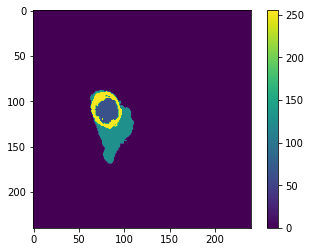

In [40]:
print(np.max(seg),np.min(seg))
plt.imshow(seg[75])
plt.colorbar()
seeg = np.array(seg)
seeg[seeg > 0] = 1


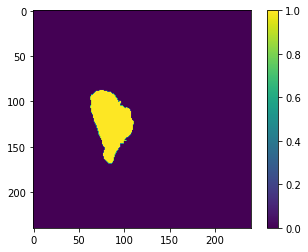

In [41]:
plt.imshow(seeg[75])
plt.colorbar()

# Isolated Connected

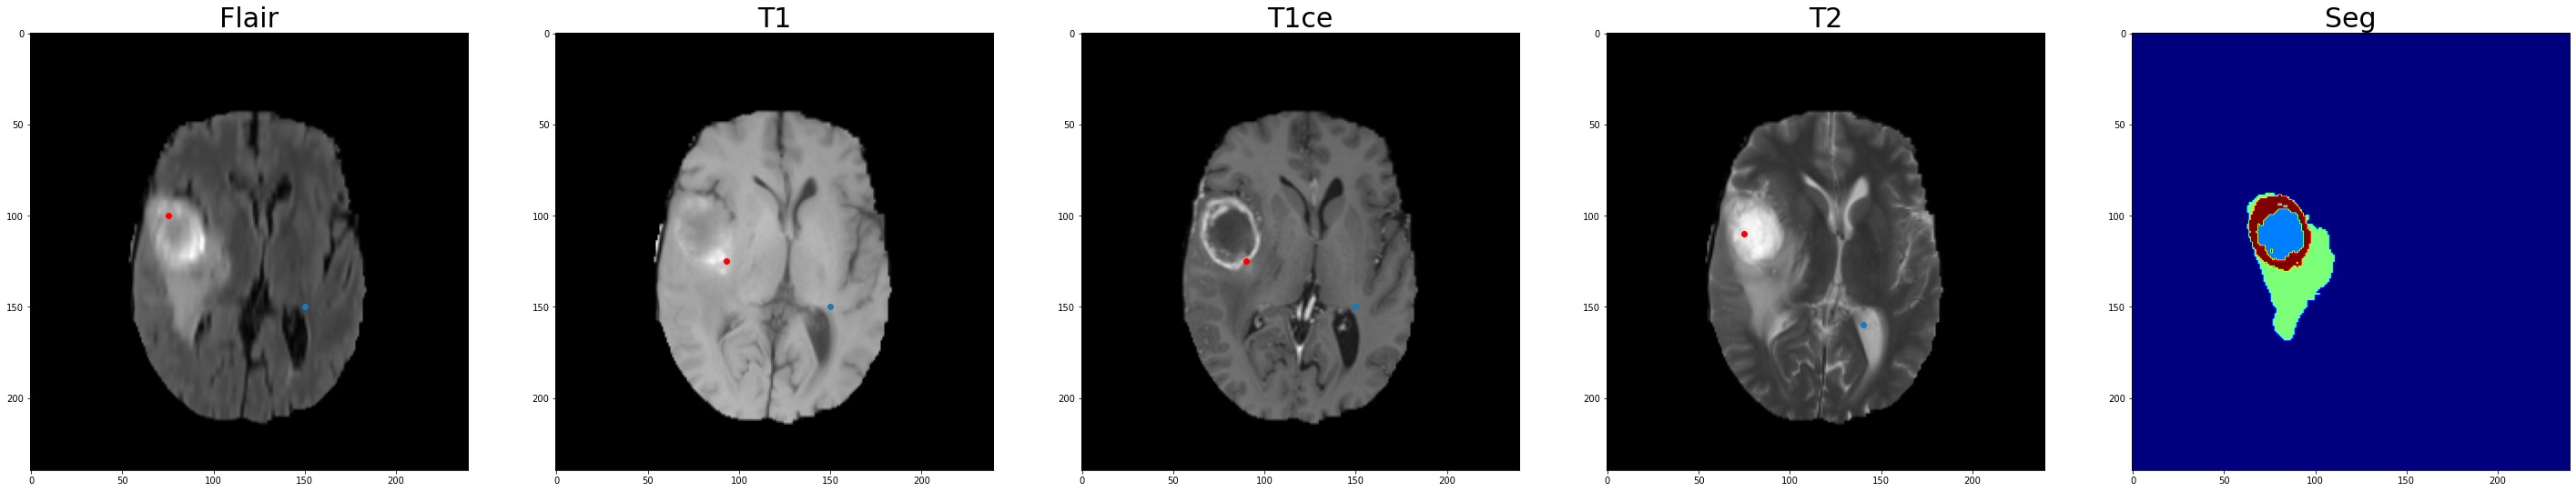

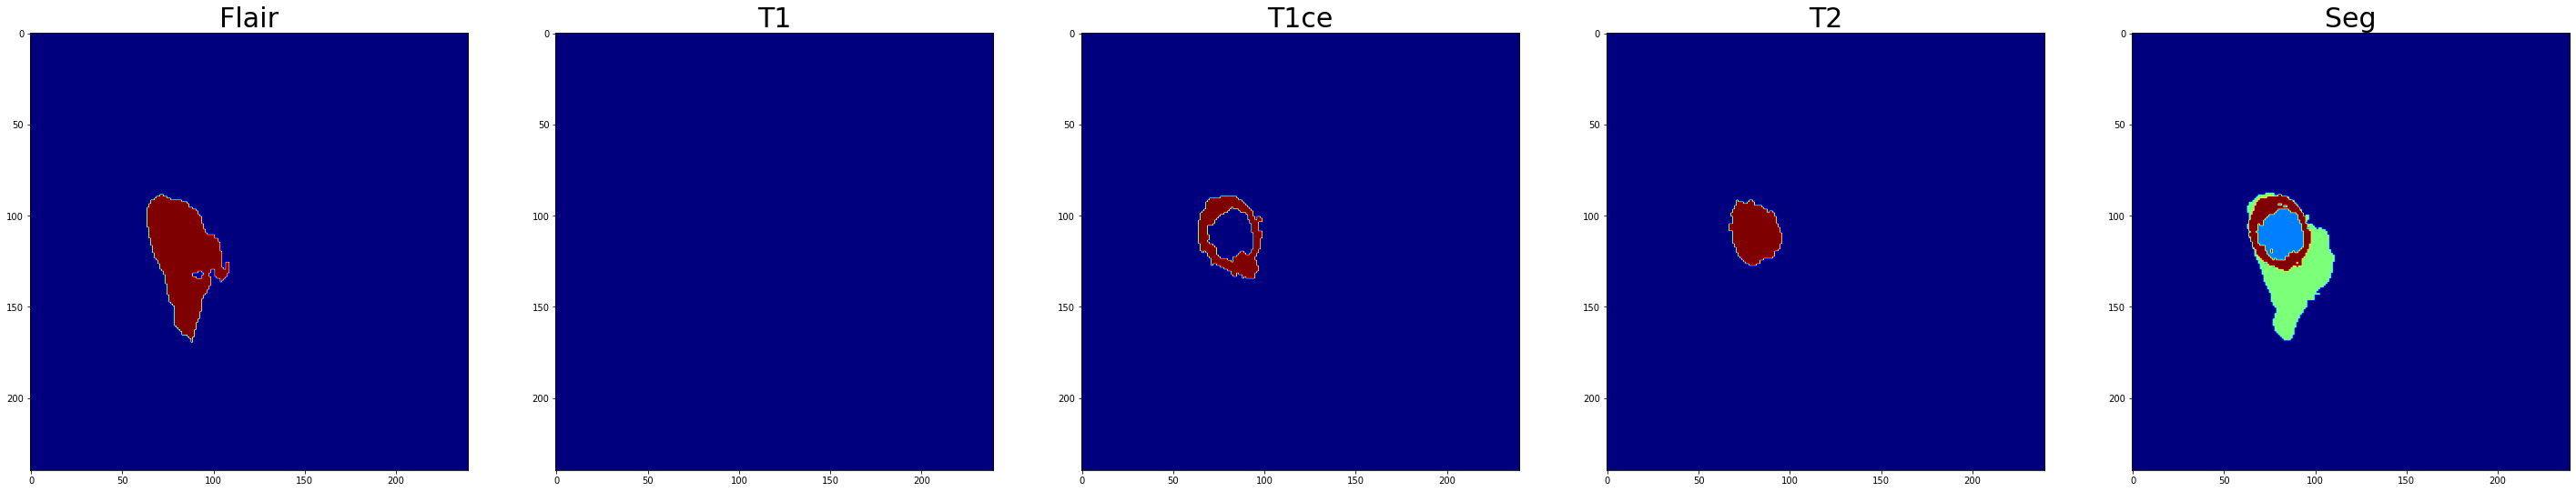

In [165]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])

seed_flair_1 = (75,100)
seed_t1_1 = (93,125)
seed_t1ce_1 = (90,125)
seed_t2_1 = (75,110)

seed_flair_2 = (150,150)
seed_t1_2 = (150,150)
seed_t1ce_2 = (150,150)
seed_t2_2 = (140,160)
Replace_value = 255

iso_flair = itk.IsolatedConnectedImageFilter(flair_slice, Lower = 120, Seed1 = seed_flair_1, Seed2 = seed_flair_2, ReplaceValue = Replace_value)
iso_t1 = itk.IsolatedConnectedImageFilter(t1_slice, Lower = 1550, Seed1 = seed_t1_1 , Seed2 = seed_t1_2, ReplaceValue = Replace_value)
iso_t1ce = itk.IsolatedConnectedImageFilter(t1ce_slice, Lower = 100, Seed1 = seed_t1ce_1 , Seed2 = seed_t1ce_2 , ReplaceValue = Replace_value)
iso_t2 = itk.IsolatedConnectedImageFilter(t2_slice, Lower = 150, Seed1 = seed_t2_1 , Seed2 = seed_t2_2 , ReplaceValue = Replace_value)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[0].scatter(seed_flair_1[0],seed_flair_1[1],color = 'r')
ax[0].scatter(seed_flair_2[0],seed_flair_2[1])
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[1].scatter(seed_t1_1[0],seed_t1_1[1],color = 'r')
ax[1].scatter(seed_t1_2[0],seed_t1_2[1])
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[2].scatter(seed_t1ce_1[0],seed_t1ce_1[1],color = 'r')
ax[2].scatter(seed_t1ce_2[0],seed_t1ce_2[1])
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[3].scatter(seed_t2_1[0],seed_t2_1[1],color = 'r')
ax[3].scatter(seed_t2_2[0],seed_t2_2[1])
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(iso_flair, cmap='jet'), ax[0].set_title('Flair',fontsize = 30);
ax[1].imshow(iso_t1, cmap='jet'), ax[1].set_title('T1',fontsize = 30);
ax[2].imshow(iso_t1ce, cmap='jet'), ax[2].set_title('T1ce',fontsize = 30);
ax[3].imshow(iso_t2, cmap='jet'), ax[3].set_title('T2',fontsize = 30);
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30);
    



# Canny-Edge Level Set Segmentation

In [92]:
def rescale_image(image, is_np = True):
  img = itk.array_from_image(image)
  img = ((img-np.min(img))/(np.max(img)-np.min(img)))*255
  img = itk.image_from_array(img)
  #img = img.astype(itk.F)
  
  return img

(<matplotlib.image.AxesImage at 0x7fa691672550>, Text(0.5, 1.0, 'Seg'))

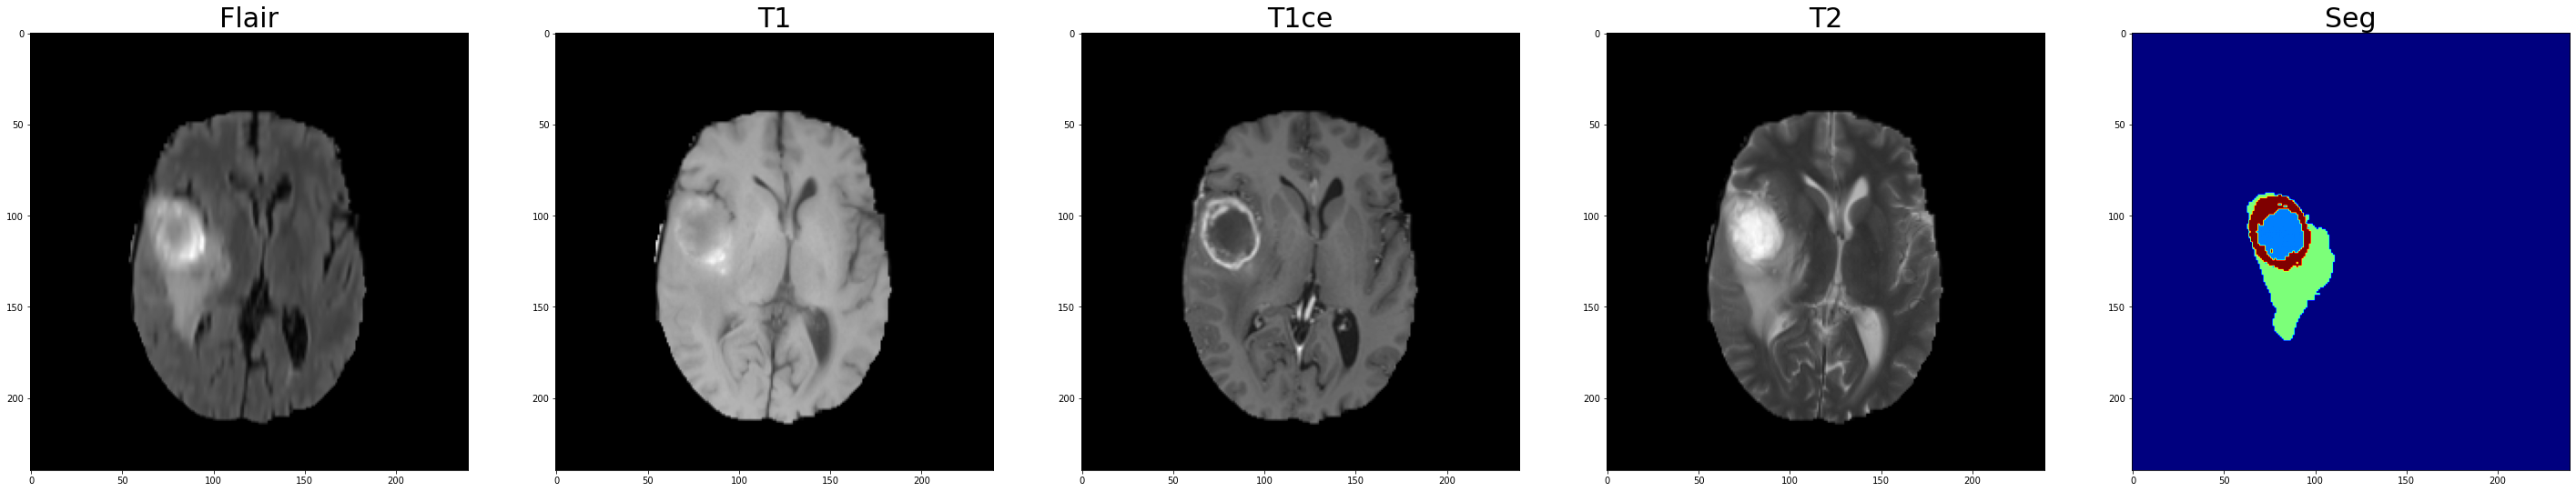

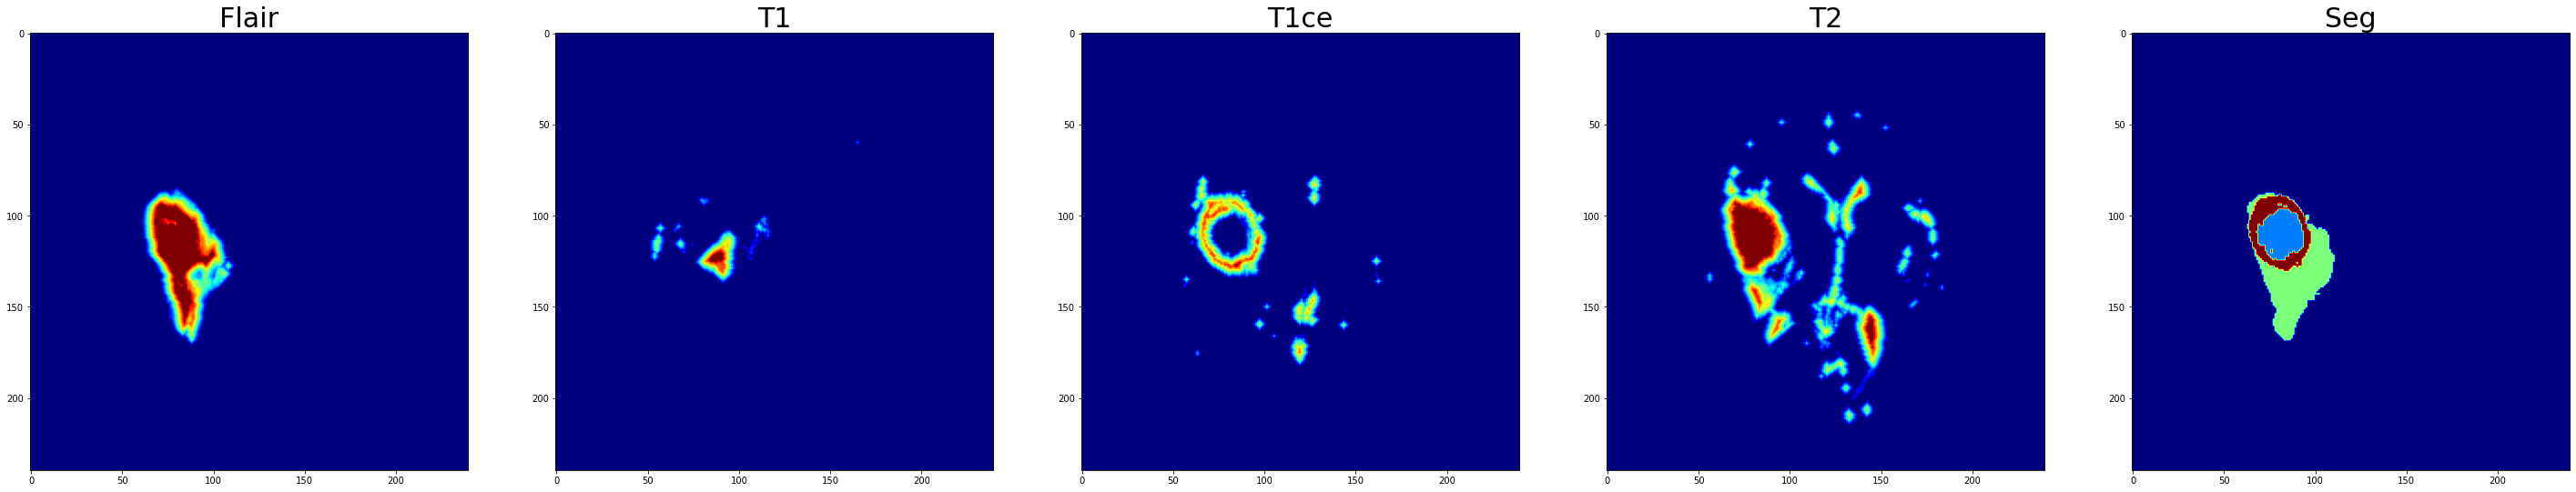

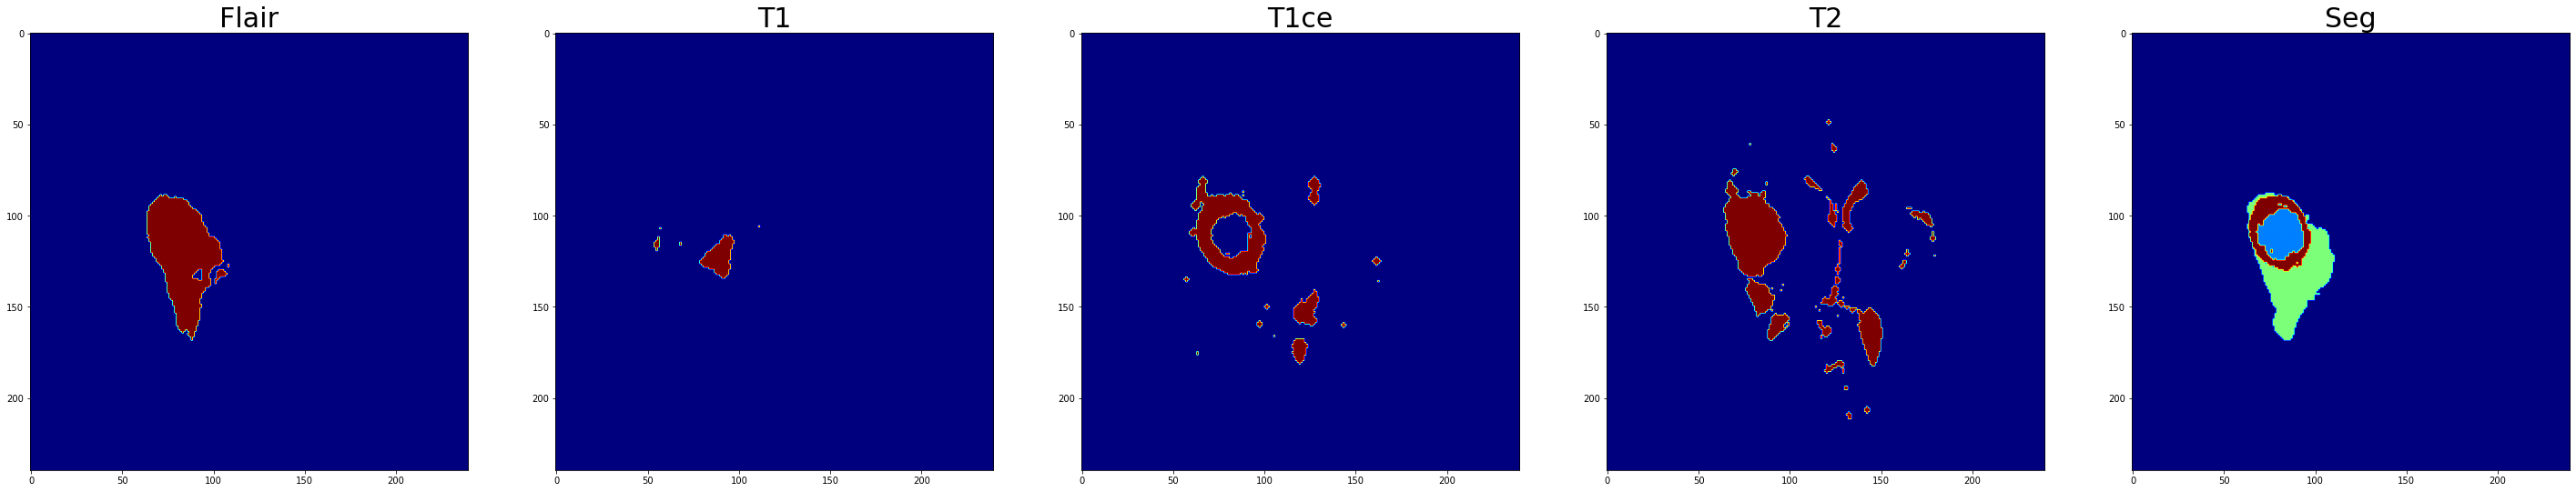

In [94]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

Ani_flair = itk.GradientAnisotropicDiffusionImageFilter(flair, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t1 = itk.GradientAnisotropicDiffusionImageFilter(t1, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t1ce = itk.GradientAnisotropicDiffusionImageFilter(t1ce, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t2 = itk.GradientAnisotropicDiffusionImageFilter(t2, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
# FeatureImage = flair_ani

canny_flair = itk.CannySegmentationLevelSetImageFilter(flair, FeatureImage = Ani_flair, AdvectionScaling = 10, CurvatureScaling = 1, 
                                                       PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 255/2)
canny_t1 = itk.CannySegmentationLevelSetImageFilter(t1, FeatureImage = Ani_t1, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                    PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 255/2)
canny_t1ce = itk.CannySegmentationLevelSetImageFilter(t1ce, FeatureImage = Ani_t1ce, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                      PropagationScaling = 0, Variance =0.1, Threshold = 3, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 255/2)
canny_t2 = itk.CannySegmentationLevelSetImageFilter(t2, FeatureImage = Ani_t2, AdvectionScaling = 10, CurvatureScaling = 0, 
                                                    PropagationScaling = 0, Variance =0.1, Threshold = 2, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 255/2)



inside_value = 255
binary_flair = itk.BinaryThresholdImageFilter(rescale_image(canny_flair), LowerThreshold = 100, UpperThreshold = 255, OutsideValue = 0, InsideValue = inside_value)
binary_t1 = itk.BinaryThresholdImageFilter(rescale_image(canny_t1), LowerThreshold = 100, UpperThreshold =255, OutsideValue = 0, InsideValue = inside_value)
binary_t1ce = itk.BinaryThresholdImageFilter(rescale_image(canny_t1ce), LowerThreshold = 60, UpperThreshold = 255, OutsideValue = 0, InsideValue = inside_value)
binary_t2 = itk.BinaryThresholdImageFilter(rescale_image(canny_t2), LowerThreshold = 100, UpperThreshold = 255, OutsideValue = 0, InsideValue = inside_value)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

# def plot_slices(slice):
slice = 75
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(canny_flair[slice], cmap='jet'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(canny_t1[slice], cmap='jet'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(canny_t1ce[slice], cmap='jet'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(canny_t2[slice], cmap='jet'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)


fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(binary_flair[slice], cmap='jet'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(binary_t1[slice], cmap='jet'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(binary_t1ce[slice], cmap='jet'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(binary_t2[slice], cmap='jet'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

# interactive(plot_slices, slice=select_slice)

# Fast Marching

In [162]:
def fastMarch(image,seed,sigma, alpha, beta, time_threshold):
    # segments = {'left ventricle': [81, 114, 1.0, -0.5, 3.0, 100], 'right ventricle': [99, 114, 1.0, -0.5, 3.0, 100], 'white matter': [56, 92, 1.0, -0.3, 2.0, 200], 'gray mater': [40, 90, 0.5, -0.3, 2.0, 100]}
    
    InternalPixelType = itk.F
    image = image.astype(InternalPixelType)
    Dimension = 2
    InternalImageType = itk.Image[InternalPixelType, Dimension]
    OutputPixelType = itk.UC
    OutputImageType = itk.Image[OutputPixelType, Dimension]
    thresholder = itk.BinaryThresholdImageFilter[InternalImageType, OutputImageType].New()

    
    thresholder.SetLowerThreshold(0.0)
    thresholder.SetUpperThreshold(time_threshold)

    thresholder.SetOutsideValue(0)
    thresholder.SetInsideValue(255)

    caster1 = itk.RescaleIntensityImageFilter[InternalImageType, OutputImageType].New()
    smoothing = itk.CurvatureAnisotropicDiffusionImageFilter[InternalImageType, InternalImageType].New()
    gradientMagnitude = itk.GradientMagnitudeRecursiveGaussianImageFilter[InternalImageType, InternalImageType].New()
    sigmoid = itk.SigmoidImageFilter[InternalImageType, InternalImageType].New()

    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)

    fastMarching = itk.FastMarchingImageFilter[InternalImageType, InternalImageType].New()


    smoothing.SetInput(image)
    gradientMagnitude.SetInput(smoothing.GetOutput())
    sigmoid.SetInput(gradientMagnitude.GetOutput())
    fastMarching.SetInput(sigmoid.GetOutput())
    thresholder.SetInput(fastMarching.GetOutput())

    smoothing.SetTimeStep(0.125)
    smoothing.SetNumberOfIterations(5)
    smoothing.SetConductanceParameter(9.0)
    
    gradientMagnitude.SetSigma(sigma)

    sigmoid.SetAlpha(alpha)
    sigmoid.SetBeta(beta)

    seed_position = [(seed[0], seed[1])]
    seed_value = 0

    NodeType = itk.LevelSetNode[InternalPixelType, Dimension]
    seed_container = itk.VectorContainer[itk.UI, NodeType].New()
    seed_container.Initialize()

    for i,p in enumerate(seed_position):
        node = NodeType()
        node.SetIndex(p)
        node.SetValue( 0.0 )
        seed_container.InsertElement( i, node )
    fastMarching.SetTrialPoints(seed_container)


    fastMarching.SetOutputSize(sigmoid.GetOutput().GetBufferedRegion().GetSize())
    stoppingTime = 500
    fastMarching.SetStoppingValue(stoppingTime)

   
    fig, ax = plt.subplots(1, 5, figsize=(20,10))
    ax[0].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[0].set_title('Input')
    ax[0].scatter(seed[0], seed[1], color='r')
    ax[1].imshow(gradientMagnitude.GetOutput(), cmap='gray')
    ax[1].set_title('Gradient Magnitude')
    ax[2].imshow(sigmoid.GetOutput(), cmap='gray')
    ax[2].set_title('Sigmoid')
    ax[3].imshow(fastMarching.GetOutput(), cmap='gray')
    ax[3].set_title('Fast march')
    ax[4].imshow(thresholder.GetOutput(), cmap='jet')
    ax[4].set_title('Thresholded')

    return gradientMagnitude.GetOutput(),sigmoid.GetOutput(),fastMarching.GetOutput(),thresholder.GetOutput()

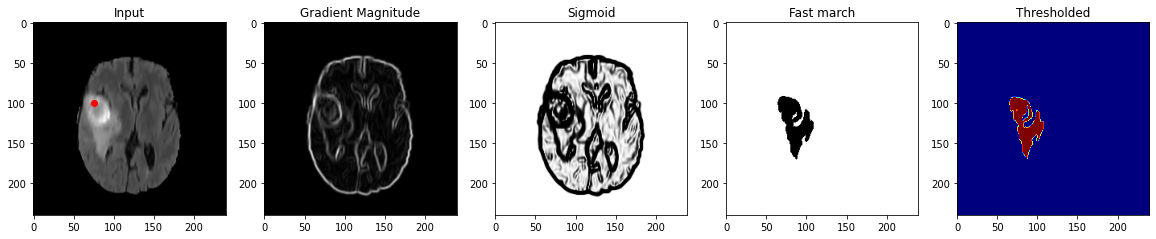

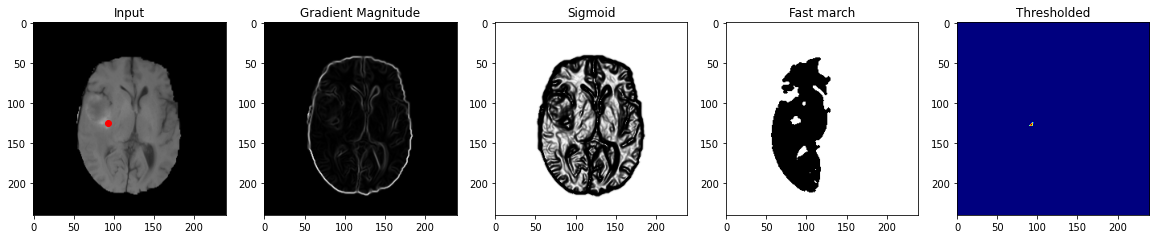

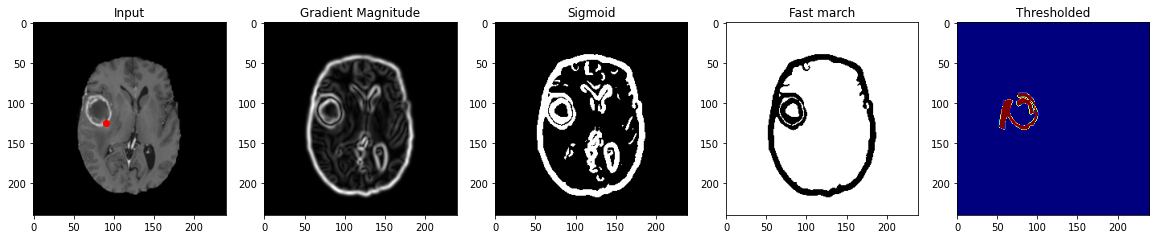

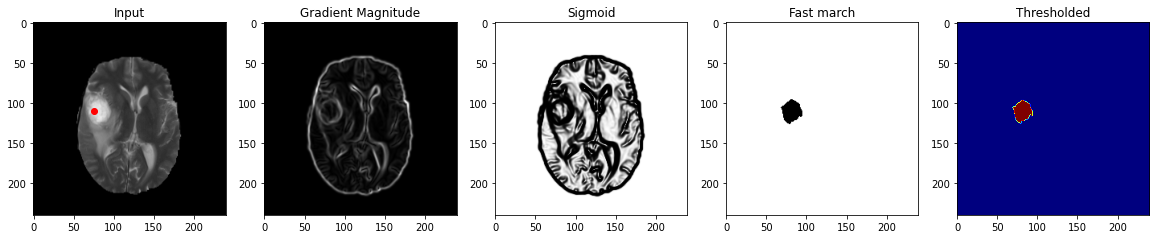

In [163]:

flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])

seed_flair = [75,100]
seed_t1 = [93,125]
seed_t1ce = [90,125]
seed_t2 = [75,110]

# flair_gm, flair_sig, flair_fm, flair_thresh =  Fast_March(flair_slice, seed_flair, sigma, -1, 4, 200)
# # t1_gm, t1_sig, t1_fm, t1_thresh =  Fast_March(t1_slice, seed_t1, sigma, alpha, beta, 0)
# t1ce_gm, t1ce_sig, t1ce_fm, t1ce_thresh =  Fast_March(t1ce_slice, seed_t1ce, sigma, -1.7, 3, time_threshold)
# t1ce_gm, t1ce_sig, t1ce_fm, t1ce_thresh =  Fast_March(t1ce_slice, seed_t1ce_2, 2, -0.3, 3.05, 1000)
# t2_gm, t2_sig, t2_fm, t2_thresh =  Fast_March(t2_slice, seed_t2, sigma, -1, 3, 1000)

# seed = [0,0]
# seed[0], seed[1],  sigma, alpha, beta, time_threshold =  [80, 110, 1.0, -0.5, 3.0, 200]

# flair_gm, flair_sig, flair_fm, flair_thresh =  Fast_March(flair, seed = [80,110], sigma = 1, alpha = -0.5, beta = 3.0, time_threshold = 200, slice_no = slice_no, is_plot = True)
# t1_gm, t1_sig, t1_fm, t1_thresh =  Fast_March(t1, seed = [80,110], sigma = 0.01, alpha = -0.5, beta = 3.0, time_threshold = 200, slice_no = slice_no, is_plot = True)
# t1ce_gm, t1ce_sig, t1ce_fm, t1ce_thresh =  Fast_March(t1ce, seed = [80,97], sigma = 2.0, alpha = -0.5, beta = 4.0, time_threshold = 400, slice_no = slice_no, is_plot = True)
# t2_gm, t2_sig, t2_fm, t2_thresh =  Fast_March(t2, seed = [80,110], sigma = 1, alpha = -0.2, beta = 5.0, time_threshold = 400,

gradmag_flair, sigmoid_flair, fastmarch_flair, binary_flair =  fastMarch(flair_slice, seed = seed_flair, sigma = 1, alpha = -1, beta = 2.8, time_threshold=500)
gradmag_t1, sigmoid_t1, fastmarch_t1, binary_t1 =  fastMarch(t1_slice, seed = seed_t1, sigma = 0.01, alpha = -1, beta = 0 , time_threshold=50)
gradmag_t1ce, sigmoid_t1ce, fastmarch_t1ce, binary_t1ce =  fastMarch(t1ce_slice, seed = seed_t1ce, sigma = 2, alpha = .001, beta = 4.2, time_threshold=55)
gradmag_t2, sigmoid_t2, fastmarch_t2, binary_t2 =  fastMarch(t2_slice, seed = seed_t2, sigma = 1, alpha = -1.3, beta = 3, time_threshold=500)

# WaterShed

(<matplotlib.image.AxesImage at 0x7fa6944f6a10>, Text(0.5, 1.0, 'Seg'))

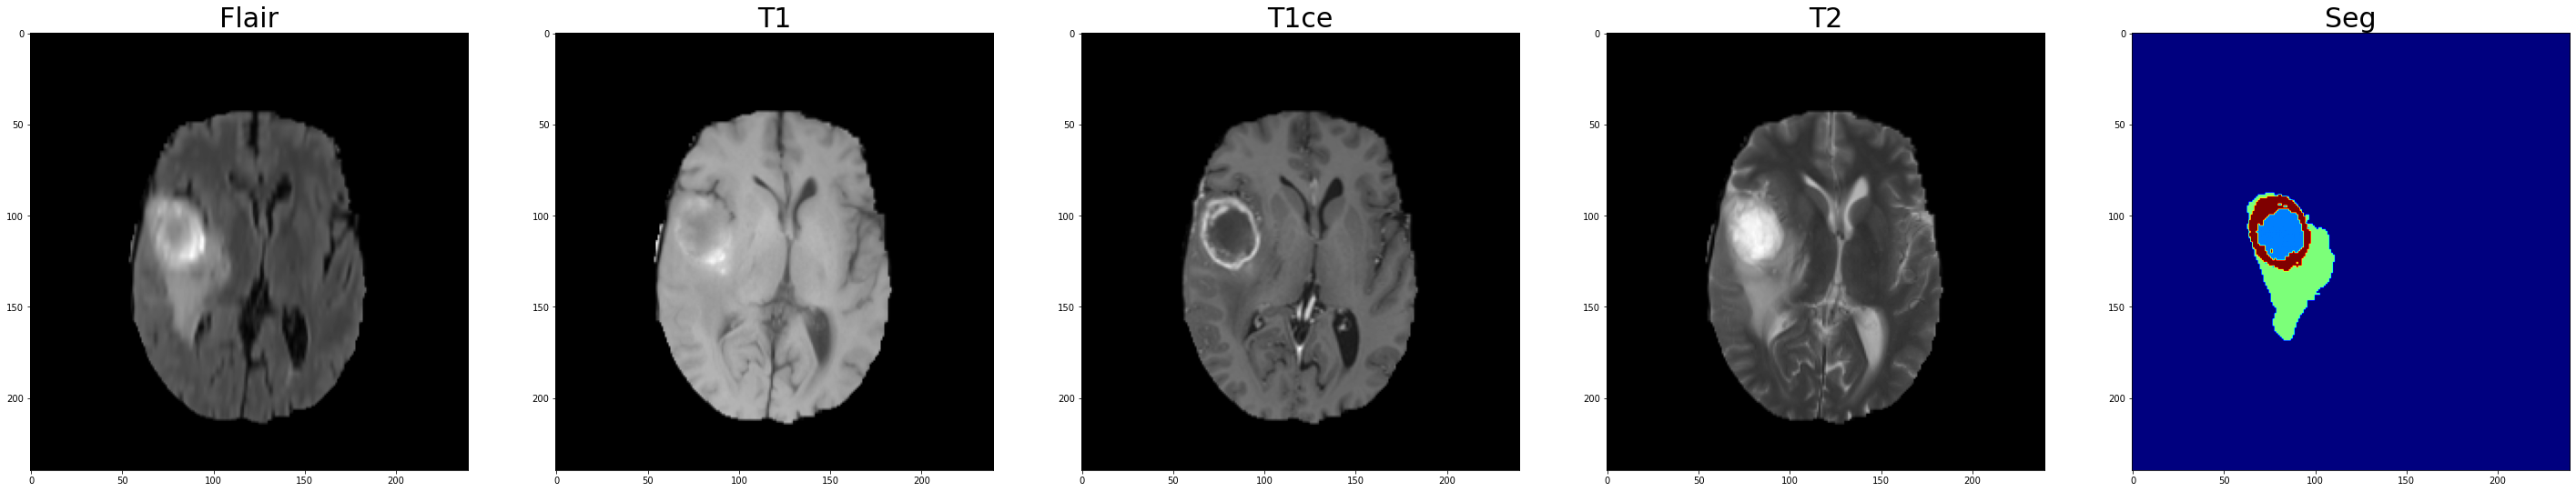

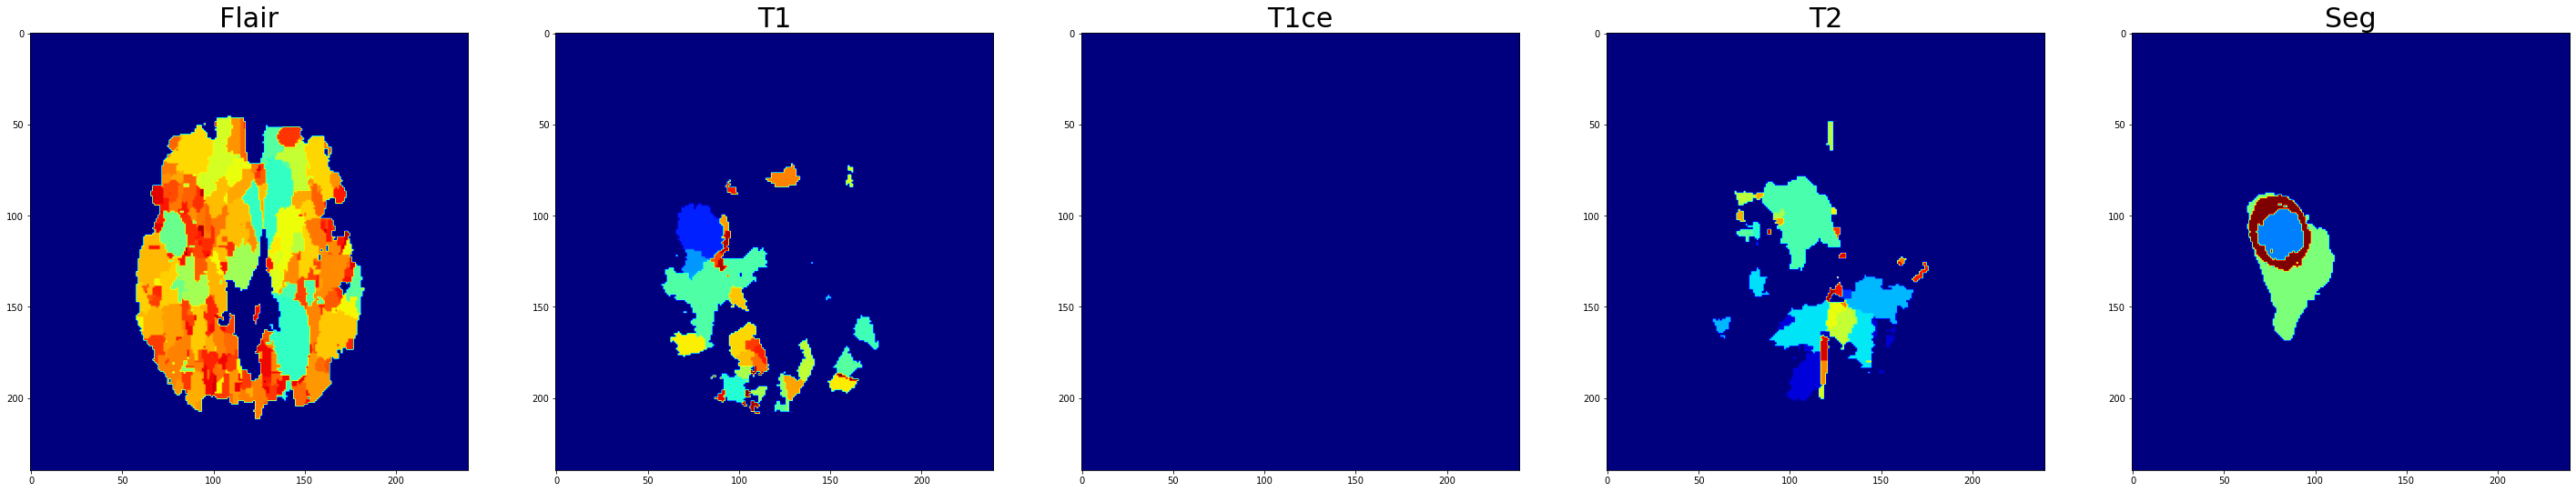

In [33]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

slice = 75

# (flair_slice, thresh = 0.06, level = 0.1 )
# t1_watershed, t1_grad_mag_filt =  water_shed_segmentation(t1_slice, thresh = 0.26, level = 0.3)
# t1ce_watershed, t1ce_grad_mag_filt =  water_shed_segmentation(t1ce_slice, thresh = 0.16, level = 0.35)
# t2_watershed, t2_grad_mag_filt =  water_shed_segmentation(t2_slice, thresh = 0.1, level = 0.2 )

flair_slice = itk.image_from_array(flair[slice])
t1_slice = itk.image_from_array(t1[slice])
t1ce_slice = itk.image_from_array(t1ce[slice])
t2_slice = itk.image_from_array(t2[slice])

diffuse_flair = itk.GradientAnisotropicDiffusionImageFilter(flair_slice,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
gradientMagnitude_flair = itk.GradientMagnitudeImageFilter(diffuse_flair)
watershed_flair = itk.WatershedImageFilter(flair,threshold = 0.06, level = 0.1)

diffuse_t1 = itk.GradientAnisotropicDiffusionImageFilter(t1_slice,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
gradientMagnitude_t1 = itk.GradientMagnitudeImageFilter(diffuse_t1)
watershed_t1 = itk.WatershedImageFilter(t1,threshold = 0.26, level = 0.3)

diffuse_t1ce =  itk.GradientAnisotropicDiffusionImageFilter(t1ce_slice,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
gradientMagnitude_t1ce = itk.GradientMagnitudeImageFilter(diffuse_t1ce)
watershed_t1ce = itk.WatershedImageFilter(t1ce,threshold = 0.001, level = 1)

diffuse_t2 =  itk.GradientAnisotropicDiffusionImageFilter(t2_slice,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
gradientMagnitude_t2 = itk.GradientMagnitudeImageFilter(diffuse_t2)
watershed_t2 = itk.WatershedImageFilter(t2,threshold = 0.1, level = 0.2)


fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(watershed_flair[slice], cmap='jet'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(watershed_t1[slice], cmap='jet'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(watershed_t1ce[slice], cmap='jet'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(watershed_t2[slice], cmap='jet'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    


# Otsu Segmentation

In [ ]:
flair = flair.astype(itk.UC)
t1 = t1.astype(itk.UC)
t1ce = t1ce.astype(itk.UC)
t2 = t2.astype(itk.UC)

otsu_flair = itk.OtsuThresholdImageFilter(flair, OutsideValue = 0, InsideValue = 1)
otsu_t1 = itk.OtsuThresholdImageFilter(t1, OutsideValue = 0, InsideValue = 1)
otsu_t1ce = itk.OtsuThresholdImageFilter(t1ce, OutsideValue = 0, InsideValue = 1)
otsu_t2 = itk.OtsuThresholdImageFilter(t2, OutsideValue = 0, InsideValue = 1)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(otsu_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(otsu_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(otsu_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(otsu_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…